# Lab 4: Error Correction

Dynamic circuits also have the potential to greatly help with error correction on quantum computers. If you are not familiar with quantum error correction, don't worry, we will start by introducing the concept with classical data, then apply that approach to quantum computers.

Error correction is important for quantum computing, since physical qubits are susceptible to noise. This means we will always have some small probability that errors occur when running our circuits. Error correction will help us deal with those small probabilities and ensure we get the correct results in the end, by correcting the errors as they occur. 

If you want more information about quantum error correction or some additional exercises, the **[Qiskit Textbook has a great section on the topic](https://learn.qiskit.org/course/quantum-hardware/introduction-to-quantum-error-correction-via-the-repetition-code)**


So, let's prepare everything we need and then start.

In [1]:
# Importing all the parts we will need.
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram


import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi

## Classical Error Correction


Why was error correction created in the first place? 

Think about talking to someone over the phone when you have bad reception. Despite your best efforts to speak clearly, sometimes the message gets changed or ruined. "Let's put lunch with Fred on the schedule for Friday" turns into "Let's punch Fred on Friday". Fred's weekend just got a whole lot worse.

Whenever you send a message, even one as simple as a bit, there is always the possibility for small errors to occur. If you send one bit of data over a wire, there may be a small chance that the bit is flipped, so instead of a `0` the recipient gets a `1`. This can happen more often if the cable is old and corroded. The same could potentially happen when storing data -- think of a CD getting scratched. In the worst case, errors could even happen during a computation in your processor.

The possibility of errors is a known problem for classical information.

Let’s imagine that the chance of a bit accidentally being flipped (AKA error to occur) is 10%. This would mean that for each bit of data we send, there is a one-in-ten chance that the bit received is incorrect. You could send a message of `0` ten times, but the received message might read `0001000000`. You can see the problem already. 

One of the simplest solutions is using some repetition. My bit of data `1` can get encoded as `111`, and likewise a `0` gets encoded as `000`. Each bit of data is now encoded using three bits instead of just one. 

Why does this help?

If we now send `000` and error occurs, then the receiver might see `001`. Since the receiver knows that the _should_ have gotten either `000` or `111`, they could deduce that it was probably `000` that was sent, and a single bit got flipped. Errors, corrected! 

But what if multiple errors occur? Our message gets turned into `011` and the recipient now assumes we meant to send `111`. True error! By using the repetition, we reduce the chance that that happens, but we don't eliminate it. So how much do we reduce the error rate by, exactly? Let's investigate! 

You can find the probability yourself on how the errors change with the code below:

In [2]:
# Probability for a 000 message to contain one error:
p1 = 0.10

# Calculating the probability of a message containing 2 or 3 errors:
p3 = 3 * p1 * p1 * (1 - p1) + p1 * p1 * p1

print("Percent chance the 000 message has one error: {}".format(p1 * 100))
print("Percent chance the 000 message has 2 or 3 errors: {:.4f}".format(p3 * 100))

Percent chance the 000 message has one error: 10.0
Percent chance the 000 message has 2 or 3 errors: 2.8000


By using repetition, we reduce our chance for errors to ruin our message down to only 2.8% of the time (when 2 or more bits are flipped). This is much better than the 10% of the time we'd encounter if only using one bit. However, we just made up the error rate of 10%. You can make up error rates too, try it. Change the `p1` error percentage to see how this would affect the probability for having 2 or more error occurring.

Knowing how repetition can help, we could implement a simple program which "encodes" the message above. It would transform 1 bit into 3 bits. Then we could also write a simple program to "decode" the message as well, taking the 3 bits and turning them back to one. In fact, that sounds like a great first exercise to try:

### Exercise 1

As an introduction let’s construct a "decoder" which decodes a 3-bit state using the qubits 0, 1, and 2 into a single bit in qubit 4, following the rules below: 

- 000->0
- 001->0
- 010->0
- 100->0
- 111->1
- 110->1
- 101->1
- 011->1

_Hint: We only need to flip bits, so gates which introduce a phase are not needed. And we only need **[basic gates](https://qiskit.org/documentation/apidoc/circuit_library.html#standard-gates)**_

In [3]:
# Creating a simple decoder for the classical case
def create_decoder(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # Expect a bit being encoded in the first 3 qubits and decode it into the 4th qubit
    # Make sure values of the first 3 qubit stays the same

    qc = QuantumCircuit(qr, cr)
    q0, q1, q2, q3 = qr
    c0 = cr

    ####### your code goes here #######
    qc.ccx(q1,q2,q3)
    qc.ccx(q0,q2,q3)
    qc.ccx(q0,q1,q3)
    qc.measure(q3,c0)
    
    
    
    return qc

Let us now check how our decoding would look like for the case we have encoded 1. 

Try to play around with different inputs (including ones with an error), to play through how your error correcting circuit would behave in these cases. 

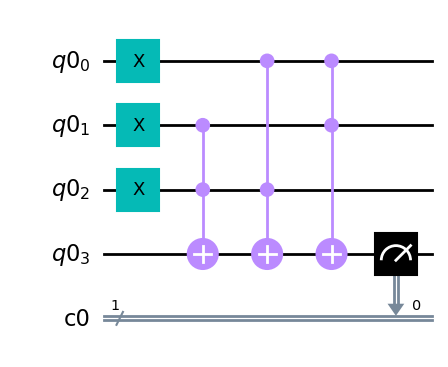

In [4]:
# We expect a bit being encoded in the first 3 qubits and decode it into the 4th qubit
qr = QuantumRegister(4)
cr = ClassicalRegister(1)

q0, q1, q2, q3 = qr

# To encode a 1. Change them to test the other encodings.
encoder = QuantumCircuit(qr, cr)
encoder.x(q0)
encoder.x(q1)
encoder.x(q2)

decoder = create_decoder(qr, cr)
qc1 = encoder.compose(decoder)

qc1.draw("mpl")

When you think your decoder works correctly, you can test it with the code below:

In [5]:
# Submit your circuit
from qc_grader.challenges.spring_2023 import grade_ex4a

grade_ex4a(create_decoder(qr, cr))

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


# The Quantum Case

## What makes the Quantum Case complicated

In the classical case having such error correction codes is relatively simple since we can just repeat the bit several times.

Of course, also other codes exist, which are more complex, but in the end all codes will have some kinds of redundancy by repeating information.


In the quantum case we cannot really do that, for 2 main reasons. 

1. We cannot copy qubits which is stated by the no cloning theorem

2. Measuring a qubit will let its state collapse, which means we be careful when working with entangled qubits


This sounds a bit discouraging, but nevertheless, we can still do error correction.

However, we will need not only several qubits to store the information (similar as above to repeat it), but also need some additional ancilla qubits, which we use as so called *stabilizers*.

The idea is that these ancillas are not itself entangled with the qubits which store the state, however, they still give us hints about possible errors when being measured. 


We will use two sets of qubits, ones used for the encoding and others used for the stabilizers. 

# Implementing a Bit-flip Repetition Code

Let’s prepare everything such that we can start with implementing the error correction.

In [6]:
# Setup a base quantum circuit for our experiments
encoding = QuantumRegister(3)
stabilizer = QuantumRegister(2)

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# Results of the encoding
results = ClassicalRegister(3)

result_b0, result_b1, result_b2 = results

# For measuring the stabilizer
syndrome = ClassicalRegister(2)

syndrome_b0, syndrome_b1 = syndrome

# The actual qubit which is encoded
state = encoding[0]

# The ancillas used for encoding the state
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

## Initializing the Qubit

To protect a quantum state from errors, we must first prepare it.
In general we can prepare the state $$|\Psi_0\rangle \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$$
In the circuit below we prepare the physical state $$|\Psi_1\rangle = |1\rangle$$

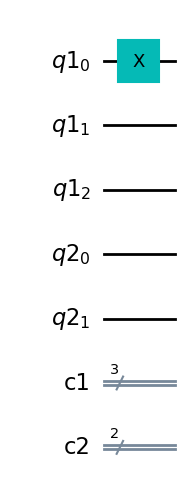

In [7]:
initial_state = initialize_circuit()

initial_state.x(encoding[0])

initial_state.draw(output="mpl")

## Encoding the Qubit

Similar to the classical case we want to use repetition in order to store the initial qubit.

So what we want to do is to map our state $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$ using our encoding $U_{en}|\Psi_0\rangle$ to the state $ (\alpha |000\rangle + \beta |111\rangle)$.

This state is an entangled state, and when 1 qubit is measured the outcome of the other 2 qubits is also known.

Therefore, we will use CX to create this entangled 3 qubit state from the initial 1 qubit state:

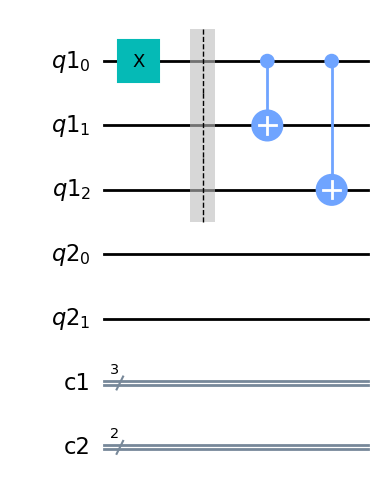

In [8]:
# Encoding using bit flip code
def encode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


# The circuit encoding our qubit
encoding_circuit = encode_bit_flip(initialize_circuit(), state, ancillas)

# The circuit including all parts so far
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")

## Preparing a Decoding Circuit

For decoding the original state, we must build a decoder which does the opposite, so a decoder $U_{de}|\Psi_0\rangle$ which maps $ (\alpha |000\rangle + \beta |111\rangle)$. to   $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$ 

Since it does exactly the opposite, we can invert our encoder:

$U_{de} = U_{en}^\dagger$

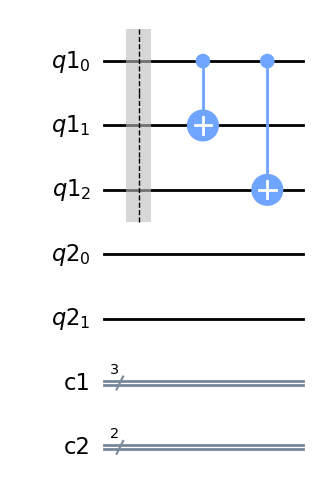

In [9]:
# Decoding (doing the reverse)
def decode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


decoding_circuit = decode_bit_flip(initialize_circuit(), state, ancillas)

decoding_circuit.draw(output="mpl")

## Measuring Stabilizers

We have seen above that we can entangle a qubit $A$ with another qubit $B$ by using a CX with $A$ as a target and $B$ as the source, (if $B$ was already in superposition or entangled.)

Afterwards we can unentangle it again by using another CX on $A$ as the target with either $B$ as the source (or another qubit which is fully entangled and correlated with $A$.)


Since we want to measure our stabilizers to get an indication of potential errors which occurred, it is important that they are NOT entangled with the qubits encoding the state.


Knowing this fact, it is clear that we need an even number of CX gates applied to each stabilizer. Additional for the stabilizer to be useful, measuring it must tell us if a bit flip error occurred and on which of the 3 encoding qubits it happened.

### Exercise 2

Compute syndrome bits, such that they can be measured to detect single bitflip errors. We have included code that will measure the syndrome bits and reset the stabilizer qubits to the `0` state.

There are different ways to do this, so let’s get a stabilizer with the simplest possible encoding:

`00` -> No error occurred 

`01` -> An error occurred  in qubit 0 (the first qubit)

`10` -> An error occurred  in qubit 1 (the second qubit)

`11` -> An error occurred  in qubit 2 (the third qubit)


*Hint: The 3 encoding qubits should be perfectly correlated, if they are not, in one of them occurred a bit flip error.*

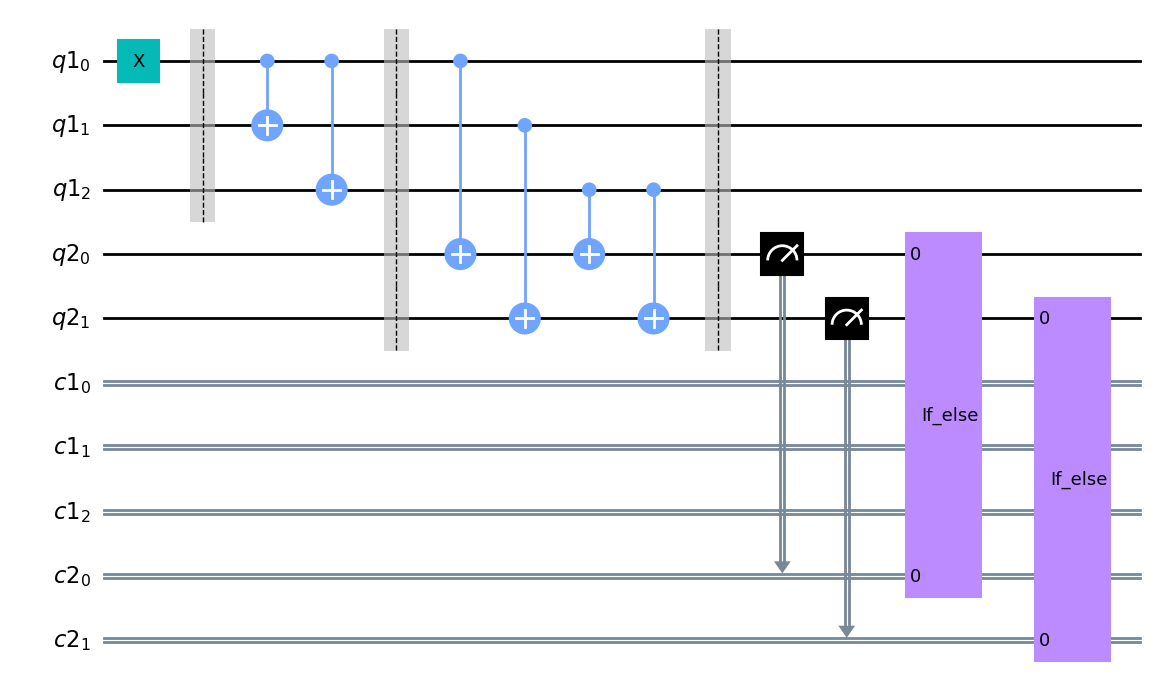

In [10]:
# Add functions such that the classical bits can be used to see which qubit is flipped in the case a single qubit is flipped.
# Use 2 classical bits for it.
# 0 = 00 = no qubit flipped
# 1 = 01 = first qubit (qubit 0) flipped
# 2 = 10 second qubit (qubit 1) flipped
# 3 = 11 = third qubit (qubit 2) flipped
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    ####### your code goes here #######
    qc.cx(encoding_q0,stabilizer_q0)
    qc.cx(encoding_q2,stabilizer_q0)
    qc.cx(encoding_q1,stabilizer_q1)
    qc.cx(encoding_q2,stabilizer_q1)
    
    ####### don't edit the code below #######
    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.x(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.x(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

In [11]:
# Submit your circuit
from qc_grader.challenges.spring_2023 import grade_ex4b

grade_ex4b(complete_circuit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Correcting Errors

Now we can construct stabilizers and by measuring them we get the error syndromes. Of course, we do not only want to get indications if an error occurred, but we also want to be able to correct the errors.

We will now use dynamic circuits to use our syndrome measurements in order to correct potential errors. Similar to the classical case we can only correct at most 1 error, if we would want to correct more, we would need a longer code with 5 encoding qubits or more.

Since we chose our syndrome measurements above in a clever way, it should now be quite easy to correct the errors, since we know exactly which of the qubits is flipped, for the case of a single error.

### Exercise 3

Correct the errors according to the measured syndromes.

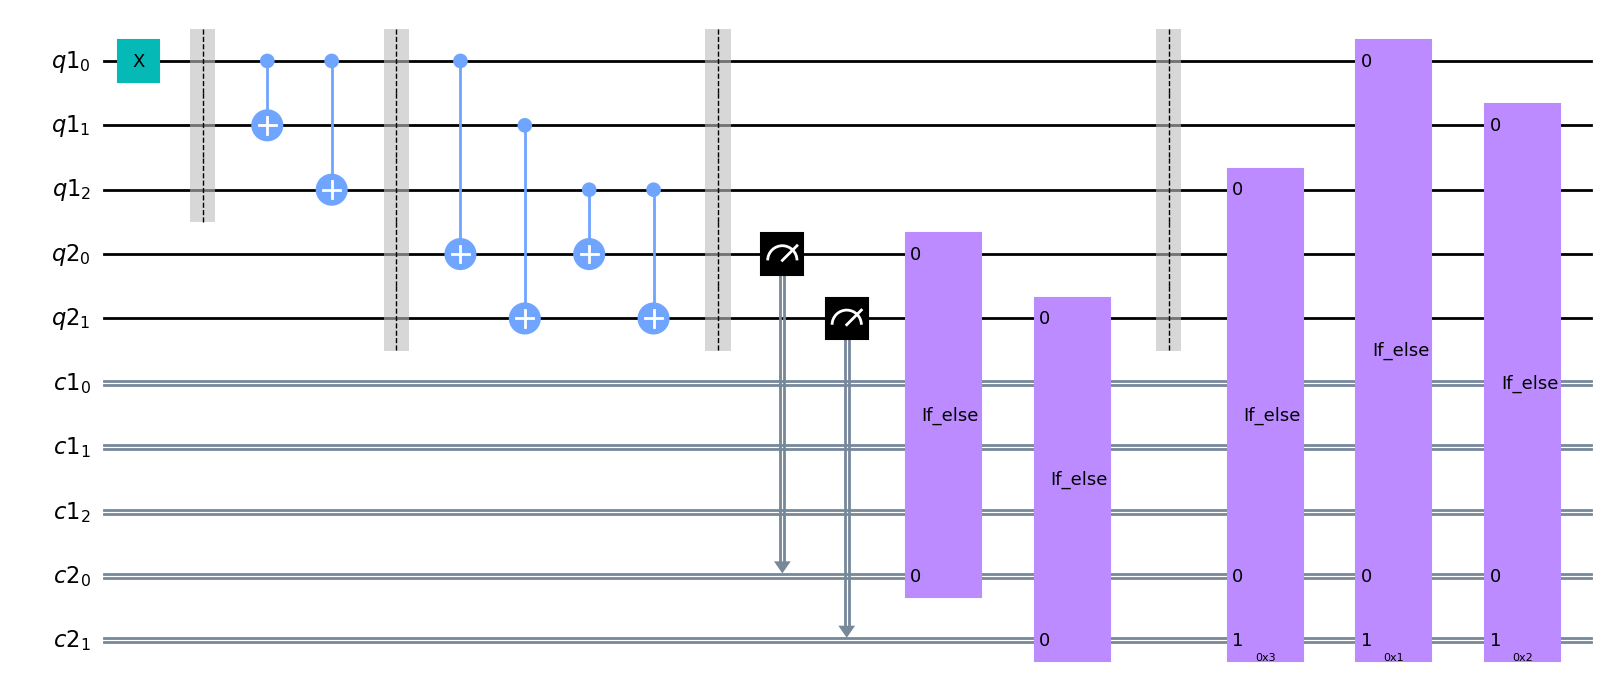

In [28]:
# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    syndrome_b0,syndrome_b1=syndrome
    
    ####### your code goes here #######
    with qc.if_test((syndrome,0b11)):
        qc.x(encoding_q2)
    with qc.if_test((syndrome,0b01)):
        qc.x(encoding_q0)
    with qc.if_test((syndrome,0b10)):
        qc.x(encoding_q1)

    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
complete_circuit = (initial_state.compose(encoding_circuit).compose(syndrome_circuit).compose(correction_circuit))
complete_circuit.draw(output="mpl")

The only part which is missing now is measuring the encoding qubits. We'll apply the decoder circuit before measuring to recover the initial state.

If everything works perfectly with no errors, it would be enough to only measure our initial qubit, however, since this is not always the case we measure all qubits to see if something wrong happened.

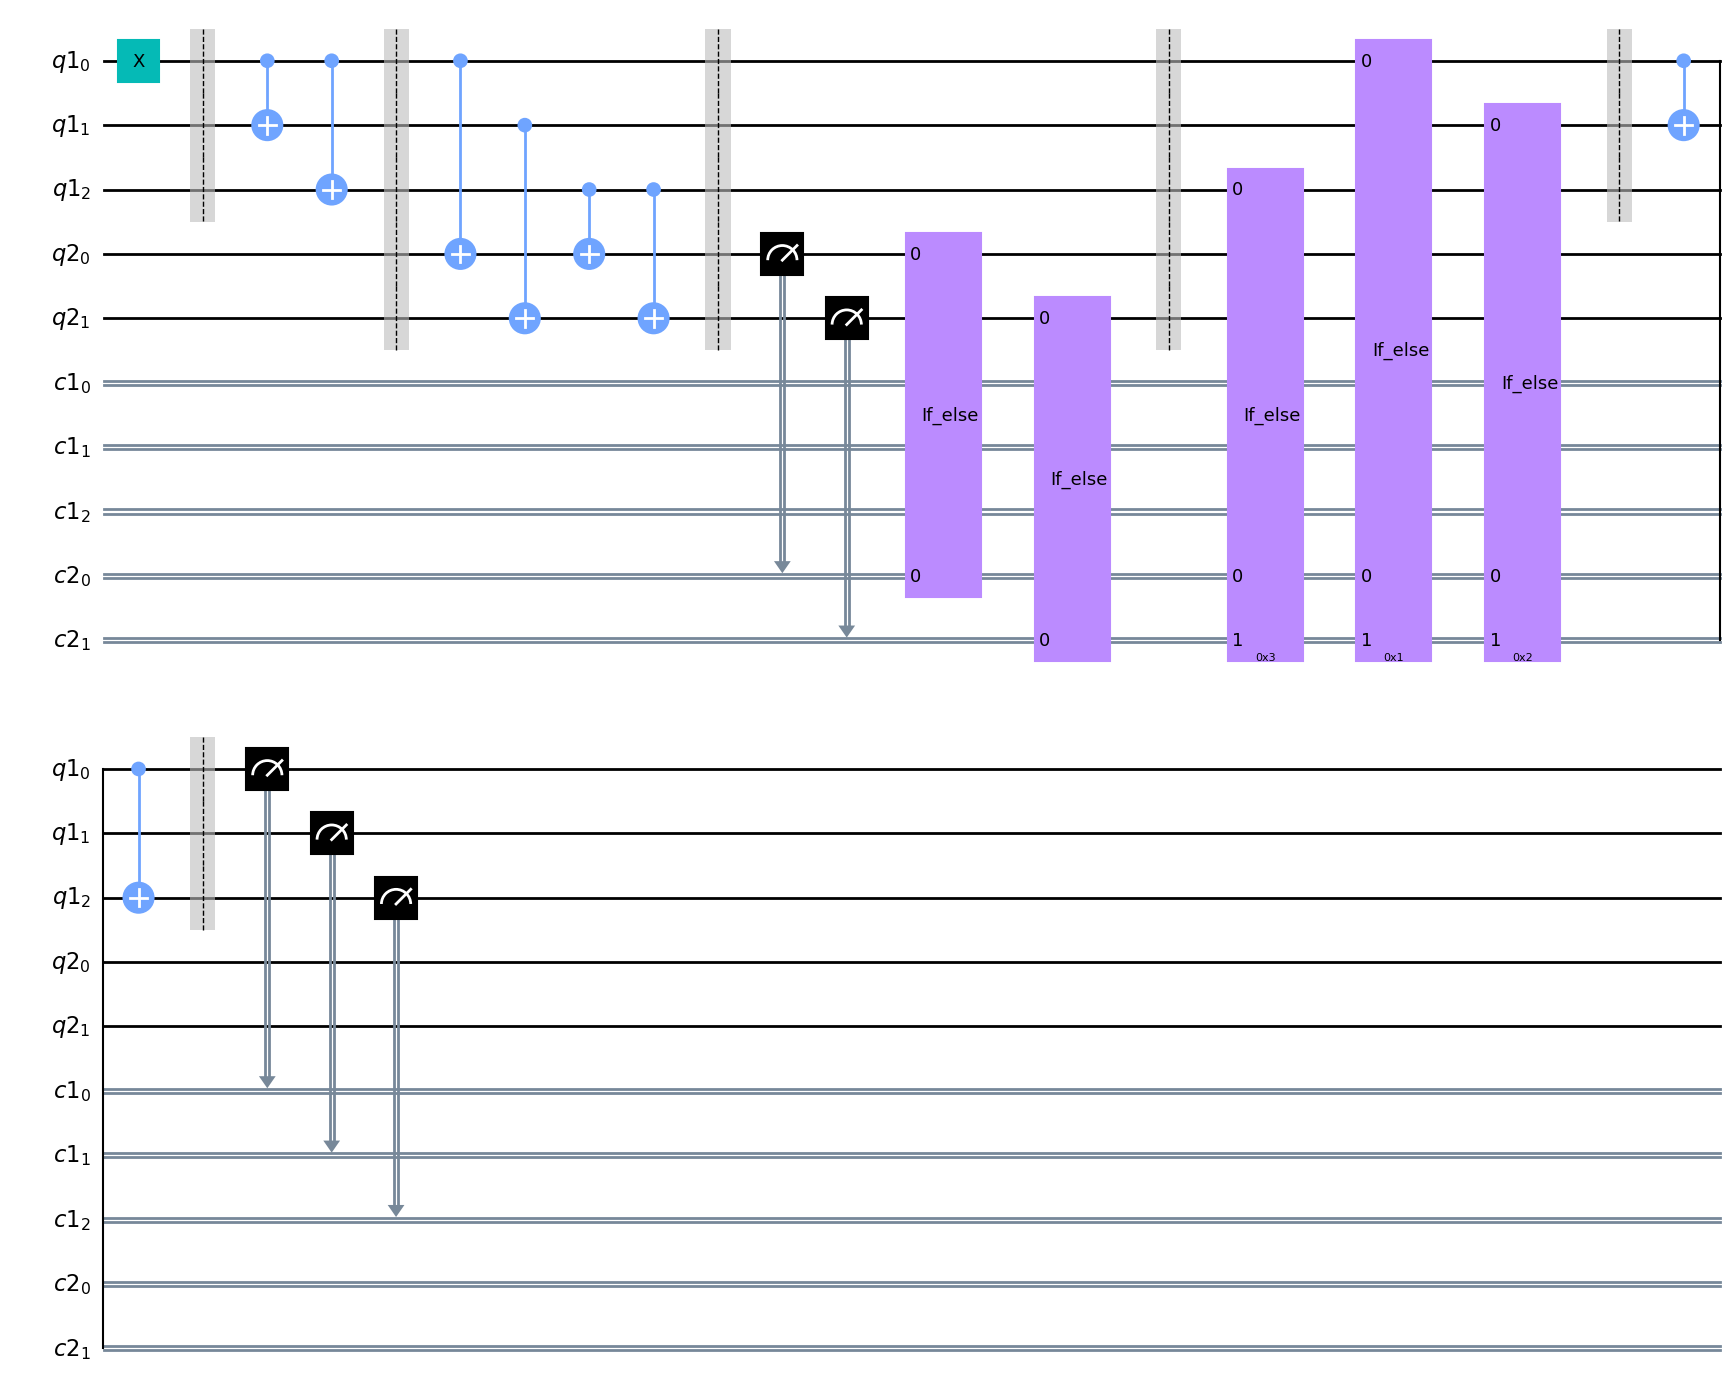

In [29]:
def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")

In [30]:
# Submit your circuit
from qc_grader.challenges.spring_2023 import grade_ex4c

grade_ex4c(complete_circuit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Ready for Testing

Now that we have everything we can test if we get the correct output. 

We will do a first test without any errors to make sure that the implementation was correct:

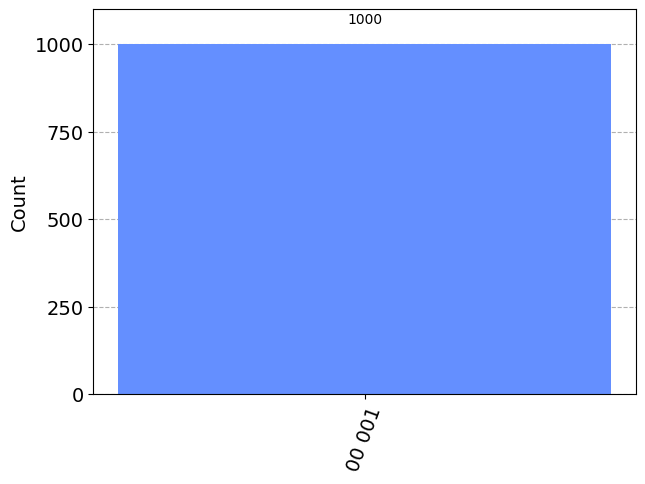

In [31]:
# We first choose a simulator as our backend without any noise
backend = Aer.get_backend("qasm_simulator")
# We run the simulation and get the counts
counts = backend.run(complete_circuit, shots=1000).result().get_counts()
# And now we plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

We can see that we get the correct results (it should give `00 001`, since we initialized our initial qubit in the state 1).

As you can see the other qubits used in the encoding are in the `0` state after the process as expected.


Now we know that our circuit works without noise, so let's add some noise! 

For this we take a simulator which simulates the ibm_manila backend including noise:

*Note: We choose this backend here, since it has a simple layout. We will take a closer look at layouts further below.*

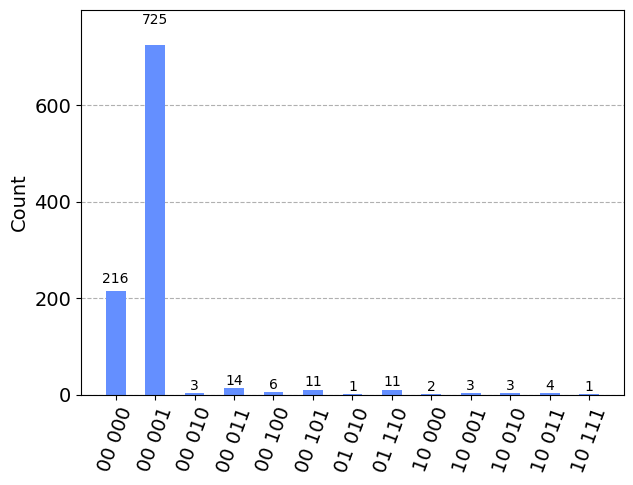

In [32]:
# We choose a simulator for Manila a 5 qubit device, includes errors
backend = FakeManilaV2()
# We run the simulation and get the counts
counts = backend.run(complete_circuit, shots=1000).result().get_counts()
# We plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

We will get some wrong results, but overall, most results are correct. This is a good sign and means even with noise our code can work.

Still, this does not tell us how good our scheme is, since we do not have a comparison to the case without error correction, so lets take a look on how good we would be without the error correction steps:

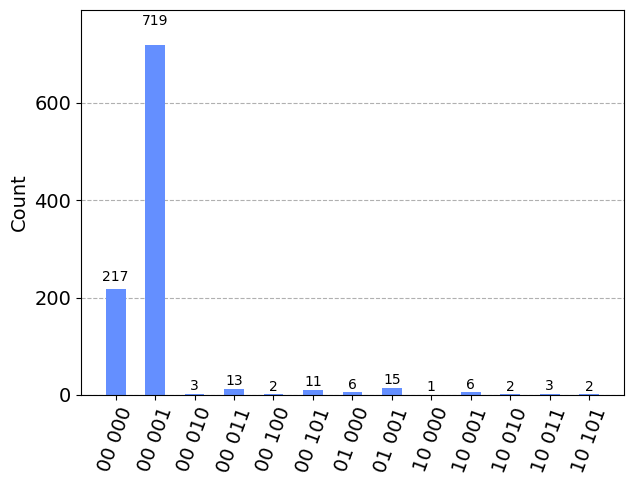

In [33]:
qc3 = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)


# We choose a again FakeManila
backend = FakeManilaV2()
# let the simulation run
counts = backend.run(qc3, shots=1000).result().get_counts()
# and plot our results
plot_histogram(counts)

We can see that the results are about the same, or even slightly worse since we do not use the encoding qubits after they are created.

When we would use these qubits for calculations, normally some errors would be introduced, this is not the case here.

On the other hand, the error correcting part can introduce errors, since it consists also of operations which take time.

For testing purposes, we build a circuit, which introduces some errors, but in a controlled way:

- We want to introduce bit flip errors, since that is what we are correcting

- We want that the errors on the 3 encoding qubits are independent of each other

- We want that we can choose how high the probability is that errors are introduced

- We want to have our input in percentage, and the output should be a circuit which generates errors with that probability.

### Exercise 4
Create a circuit to add noise as defined above.

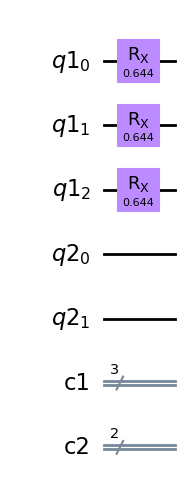

In [110]:
# Add some errors as defined above (only add errors to the encoding qubits)
import numpy as np
def make_some_noise(qc, encoding, syndrome, error_percentage):
    encoding_q0, encoding_q1, encoding_q2 = encoding
    syndrome_b0, syndrome_b1 = syndrome

    ####### your code goes here #######
    err=error_percentage/100
    prob=math.sin(err)**2
    ang=2*(np.arcsin(math.sqrt(err)))
    qc.rx(ang,encoding_q0)
    qc.rx(ang,encoding_q1)
    qc.rx(ang,encoding_q2)
    

    return qc


# Constructing a circuit with 10% error rate (for each of the encoding qubit)
noise_circuit = make_some_noise(initialize_circuit(), encoding, syndrome, 10)
noise_circuit.draw(output="mpl")

Use the code below to test your function create a circuit introducing a 10% error rate.

In [111]:
# Submit your circuit
from qc_grader.challenges.spring_2023 import grade_ex4d

grade_ex4d(noise_circuit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


We can now test how good our error correction works, when we introduce errors with a 10% probability:

In [ ]:
qc4 = (
    initial_state.compose(encoding_circuit)
    .compose(noise_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)


# We choose again FakeManila
backend = FakeManilaV2()
# let the simulation run
counts = backend.run(qc4, shots=1000).result().get_counts()
# and plot our results
plot_histogram(counts)

We can see that our results got worse, but we still get `001` in most cases. 

We now have successfully made our first error correction code and even tested it.


Our kind of error correction does of course only correct bit flip errors, if we also want to correct phase errors, we will need a different scheme and more qubits.

If you want to learn more about error correction you can also look at: 

https://learn.qiskit.org/course/ch-labs/lab-10-quantum-error-correction

# Short Outlook: Error Correction and Hardware Layout

We have used a simulator above, which already simulates the hardware, still if we want to run something more complex on a real device, we will also have to take the layout into consideration.

The layout of the device is important, since not all qubits are connected with each other, as in the ideal case, so we have to think about that, else a lot of swap operations will be used, which consist of 3 cx operations, which of course can also introduce errors.



Suppose we have the following line of qubits on our actual device

    0 - 1 - 2 - 3 - 4 

How would one map these physical qubits to the logical qubits we used above in our error correcting circuit?)  

We assume here that the initial connecting of the qubits (entangling them) is "easier" than the error correction parts, since we might want to repeat the error correcting part several times, so only considering the error correction part how would you map these qubits?



With the code below you can see how different layouts can lead to different circuits.



In [ ]:
from qiskit.circuit import IfElseOp

# Fill in a better layout to test!!
initial_layout = [0, 1, 2, 3, 4]

# We use Manila as our potential backend, since it has the wanted layout
backend = FakeManilaV2()

# Temporary workaround for fake backends. For real backends this is not required.
backend.target.add_instruction(IfElseOp, name="if_else")

# And now we transpile the circuit for the backend.
qc_transpiled = transpile(complete_circuit, backend, initial_layout=initial_layout)

qc_transpiled.draw()

No layout is perfect, especially since in the beginning to entangle the 3 qubits we need different connections than later for the error correction.



The layout [0, 4, 2, 1, 3] could sense, since then we have direct connections for all needed CX for the correction, and that part is potentially run several times.

We could also think about how we could do the initial setup (entangling) better with these qubits, since we could also use the qubits which are used as stabilizers first to construct the circuit.



To show you that it can also be quite different let's look at the following layout how would you map the qubits? 


    2 - 3 - 4 
            |
           15
            |
           22

Similar to above the layout [2, 4, 22, 3, 15] would make the sense, since then we have again direct connections for all needed CX

We can see that there is not really a difference between these layouts, since both layouts are a simple line. If you would, however, look at the backend IBM_Quito you can see, that there are also other 5 qubit devices. We chose Manila since its layout is better suited for this exercise.


These small examples should show that on actual hardware you must take care of the layout of the qubits!

**This will be especially important in the bonus exercise!**